In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout , TimeDistributed , Conv1D , MaxPooling1D , Flatten , Bidirectional
from keras.callbacks import ModelCheckpoint
import pickle
import matplotlib.pyplot as plt

In [2]:
stock = yf.Ticker("RELIANCE.NS")
df = stock.history(period='1d',
start = datetime.date.today() - relativedelta(years=5),end = datetime.date.today())

In [3]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-07-16 00:00:00+05:30,1072.728708,1081.604689,1046.637190,1049.709595,6658302,0.0,0.0
2018-07-17 00:00:00+05:30,1051.758216,1068.973757,1043.272383,1065.462402,6530578,0.0,0.0
2018-07-18 00:00:00+05:30,1071.363329,1077.410661,1050.782713,1065.657349,4726480,0.0,0.0
2018-07-19 00:00:00+05:30,1066.388857,1087.554699,1059.609903,1077.654541,5485122,0.0,0.0
2018-07-20 00:00:00+05:30,1085.994018,1110.476136,1084.530893,1100.868652,8094154,0.0,0.0
...,...,...,...,...,...,...,...
2023-07-10 00:00:00+05:30,2688.899902,2756.000000,2675.000000,2735.050049,15340262,0.0,0.0
2023-07-11 00:00:00+05:30,2752.899902,2770.000000,2737.600098,2764.699951,9262001,0.0,0.0
2023-07-12 00:00:00+05:30,2766.300049,2802.000000,2761.649902,2767.750000,8645662,0.0,0.0


In [4]:
df_minmax = df.iloc[:,3:4]

In [5]:
min_max = MinMaxScaler(feature_range=(0,1))
df_minmax = min_max.fit_transform(df_minmax)

In [6]:
training_size=int(len(df_minmax)*0.65)
test_size=len(df_minmax)-training_size
train_data,test_data=df_minmax[0:training_size,:],df_minmax[training_size:len(df_minmax),:1]

In [9]:
def makeFeature(data,feature=24):
    x = list()
    y = list()
    for i in range(len(data)-feature-1):
        x.append(data[i:(i + feature),0])
        y.append(data[i + feature,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [10]:
x_train,y_train = makeFeature(train_data)

In [11]:
x_test,y_test = makeFeature(test_data)

In [12]:
x_train.shape[0]

777

In [21]:
x_train

array([[0.09393765, 0.10203961, 0.10213987, ..., 0.16136063, 0.15644441,
        0.15792433],
       [0.10203961, 0.10213987, 0.10831025, ..., 0.15644441, 0.15792433,
        0.17355102],
       [0.10213987, 0.10831025, 0.12024969, ..., 0.15792433, 0.17355102,
        0.17972133],
       ...,
       [0.80568398, 0.80078715, 0.79783861, ..., 0.87311392, 0.92380165,
        0.91426404],
       [0.80078715, 0.79783861, 0.77012318, ..., 0.92380165, 0.91426404,
        0.92203268],
       [0.79783861, 0.77012318, 0.76853352, ..., 0.91426404, 0.92203268,
        0.93595443]])

In [20]:
test_data

array([[0.95487585],
       [0.93874903],
       [0.89880397],
       [0.90131642],
       [0.8881895 ],
       [0.91857145],
       [0.90131642],
       [0.88654861],
       [0.85457712],
       [0.85537195],
       [0.8363993 ],
       [0.82757955],
       [0.83539942],
       [0.83698896],
       [0.84711624],
       [0.86157642],
       [0.86396092],
       [0.88372839],
       [0.87588291],
       [0.8451677 ],
       [0.81752912],
       [0.82229799],
       [0.76612353],
       [0.77745586],
       [0.75979073],
       [0.83237391],
       [0.79117257],
       [0.80599174],
       [0.78748055],
       [0.81906743],
       [0.82719507],
       [0.78894201],
       [0.76553387],
       [0.77540474],
       [0.7939929 ],
       [0.81365767],
       [0.81493957],
       [0.78965987],
       [0.77453294],
       [0.77096925],
       [0.78671133],
       [0.7541758 ],
       [0.72181983],
       [0.73920281],
       [0.76732859],
       [0.76689262],
       [0.7707642 ],
       [0.769

In [19]:
train_data.shape

(802, 1)

In [22]:
x_train = np.reshape(x_train,(x_train.shape[0],1,24,1))
x_test = np.reshape(x_test,(x_test.shape[0],1,24,1))

In [25]:
x_train.shape



(777, 1, 24, 1)

In [26]:
x_test.shape

(407, 1, 24, 1)

In [27]:
model = Sequential([
    TimeDistributed(Conv1D(filters = 6,kernel_size = 3, activation = 'relu'),input_shape=(None, 24, 1)),
    TimeDistributed(MaxPooling1D()),
    TimeDistributed(Flatten()),
    LSTM(100,return_sequences=False,input_shape=(x_train.shape[1],1)),
    Dropout(0.42),
#     LSTM(50,return_sequences=False),
#     Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam',loss='mean_squared_error')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 22, 6)      24        
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 11, 6)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 66)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               66800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                        

In [29]:
checkpoint = ModelCheckpoint(filepath='model.hdf5',
                             verbose=1,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True)

In [30]:
stock_price = model.fit(x_train,y_train,epochs=100,batch_size=24,verbose=1,callbacks=checkpoint)

Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1214

33/33 [==============================] - 3s 6ms/step - loss: 0.1094
Epoch 2/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0145

33/33 [==============================] - 0s 6ms/step - loss: 0.0138
Epoch 3/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0075

33/33 [==============================] - 0s 7ms/step - loss: 0.0070
Epoch 4/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0039

33/33 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.0032

33/33 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0030

33/33 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0030

33/33 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 8/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0027

33/33 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.0024

33/33 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 10/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0026

33/33 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0021

33/33 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0025

33/33 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0023

33/33 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 14/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0019

33/33 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 15/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0020

33/33 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0024

33/33 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0021

33/33 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0020

33/33 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0018

33/33 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0019

33/33 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0020

33/33 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 22/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0023

33/33 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0018

33/33 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 24/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0017

33/33 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 25/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0018

33/33 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 26/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0017

33/33 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 27/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0018

33/33 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 28/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0017

33/33 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 29/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0020

33/33 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 30/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0018

33/33 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 31/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0016

33/33 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 32/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0017

33/33 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 33/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0016

33/33 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 34/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0018

33/33 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 35/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0018

33/33 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 36/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0017

33/33 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 37/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0014

33/33 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 38/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0015

33/33 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 39/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0017

33/33 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 40/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0016

33/33 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 41/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0018

33/33 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 42/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0014

33/33 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 43/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0015

33/33 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 44/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0015

33/33 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 45/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0016

33/33 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 46/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0015

33/33 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 47/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0014

33/33 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 48/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0014

33/33 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 49/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0015

33/33 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 50/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0017

33/33 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 51/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0014

33/33 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 52/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0015

33/33 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 53/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0016

33/33 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 54/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0014

33/33 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 55/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0013

33/33 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 56/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0016

33/33 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 57/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0014

33/33 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 58/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 59/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0014

33/33 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 60/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0014

33/33 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 61/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0014

33/33 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 62/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0015

33/33 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 63/100
32/33 [============================>.] - ETA: 0s - loss: 0.0015

33/33 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 64/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 65/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 66/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 67/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 68/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 69/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0013

33/33 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 70/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 71/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0013

33/33 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 72/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0014

33/33 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 73/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0013

33/33 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 74/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0011

33/33 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 75/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0010

33/33 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 76/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0010    

33/33 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 77/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 78/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0011

33/33 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 79/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0010    

33/33 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 80/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0011

33/33 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 81/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0011

33/33 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 82/100
33/33 [==============================] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 83/100
33/33 [==============================] - ETA: 0s - loss: 0.0011

33/33 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 84/100
26/33 [======================>.......] - ETA: 0s - loss: 9.7029e-04

33/33 [==============================] - 0s 6ms/step - loss: 9.7762e-04
Epoch 85/100
33/33 [==============================] - ETA: 0s - loss: 0.0010

33/33 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 86/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0011

33/33 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 87/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 88/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 89/100
25/33 [=====================>........] - ETA: 0s - loss: 0.0010    

33/33 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 90/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0010

33/33 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 91/100
26/33 [======================>.......] - ETA: 0s - loss: 9.1677e-04

33/33 [==============================] - 0s 4ms/step - loss: 9.9801e-04
Epoch 92/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0011

33/33 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 93/100
24/33 [====================>.........] - ETA: 0s - loss: 0.0010    

33/33 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 94/100
23/33 [===================>..........] - ETA: 0s - loss: 9.6383e-04

33/33 [==============================] - 0s 5ms/step - loss: 9.6674e-04
Epoch 95/100
25/33 [=====================>........] - ETA: 0s - loss: 9.4827e-04

33/33 [==============================] - 0s 4ms/step - loss: 9.7182e-04
Epoch 96/100
26/33 [======================>.......] - ETA: 0s - loss: 9.5763e-04

33/33 [==============================] - 0s 4ms/step - loss: 9.8594e-04
Epoch 97/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0010    

33/33 [==============================] - 0s 5ms/step - loss: 9.8617e-04
Epoch 98/100
33/33 [==============================] - ETA: 0s - loss: 9.7125e-04

33/33 [==============================] - 0s 5ms/step - loss: 9.7125e-04
Epoch 99/100
33/33 [==============================] - ETA: 0s - loss: 9.3941e-04

33/33 [==============================] - 0s 9ms/step - loss: 9.3941e-04
Epoch 100/100
23/33 [===================>..........] - ETA: 0s - loss: 0.0012

33/33 [==============================] - 0s 8ms/step - loss: 0.0011


In [31]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

13/13 [==============================] - 0s 2ms/step


In [32]:
train_predict=min_max.inverse_transform(train_predict)
test_predict=min_max.inverse_transform(test_predict)


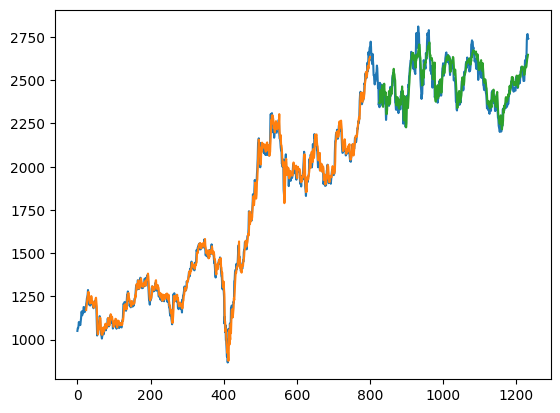

In [33]:
look_back=24
trainPredictPlot = np.empty_like(df_minmax)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_minmax)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_minmax)-1, :] = test_predict
# plot baseline and predictions
plt.plot(min_max.inverse_transform(df_minmax))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:
pickle.dump(model, open('model_val_best.pkl', 'wb'))


In [35]:
pickle.dump(min_max,open('minmax.pkl','wb'))